# BL40A2020 Wireless Communication Systems

## Assignment  week 5: Optimal demodulation

## Author: Vili Raunola

### Follow the steps done in the [notes](https://github.com/pedrohjn/wireless-comm/blob/master/Week%205/week5.ipynb) to analyze the *[8PSK](https://komm.readthedocs.io/en/latest/komm.PSKModulation/)* modulation

**1. Signal constelation with noise for $E_b/N_0 = 12$dB. You can reuse the code provided in this [link](https://github.com/rwnobrega/komm/blob/master/demo/constellations.ipynb).**

In [34]:
import numpy as np
import matplotlib.pylab as plt
import komm
import math
import sympy as sp
sp.init_printing() 
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
import warnings
warnings.filterwarnings('ignore')

In [54]:

# Functions from the provided link!
def constellation_demo(modulation, noise_power_db, xlim, ylim):
    awgn = komm.AWGNChannel()

    num_symbols = 10000
    noise_power = 10**(noise_power_db / 10)
    awgn.signal_power = modulation.energy_per_symbol
    awgn.snr = awgn.signal_power / noise_power
    num_bits = modulation.bits_per_symbol * num_symbols
    bits = np.random.randint(2, size=num_bits)
    sentword = modulation.modulate(bits)
    recvword = awgn(sentword)

    _, ax = plt.subplots(figsize=(16, 10))
    ax.scatter(recvword.real, recvword.imag, color='xkcd:light blue', s=1)
    ax.scatter(modulation.constellation.real, modulation.constellation.imag, color='xkcd:blue', s=8**2)
    for (i, point) in enumerate(modulation.constellation):
        binary_label = ''.join(str(b) for b in komm.int2binlist(modulation.labeling[i], width=modulation.bits_per_symbol))
        ax.text(point.real, point.imag + 0.075 * xlim[0], binary_label, horizontalalignment='center')
    ax.set_title(repr(modulation))
    ax.set_xlabel('Re')
    ax.set_ylabel('Im')
    ax.axis('square')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(color='r', linestyle='--', linewidth=1)
    info_text = 'SNR = {:.1f} dB\n'.format(10*np.log10(awgn.snr))
    info_text += 'Eb/N0 = {:.1f} dB'.format(10*np.log10(awgn.snr / modulation.bits_per_symbol))
    ax.text(1.125 * xlim[1], 0.0, info_text, horizontalalignment='left', verticalalignment='center')
    plt.show()


def psk_constellation_demo(order, amplitude, phase_offset, labeling, noise_power_db):
    psk_modulation = komm.PSKModulation(order, amplitude, phase_offset, labeling)
    constellation_demo(psk_modulation, noise_power_db, xlim=[-3.0, 3.0], ylim=[-3.0, 3.0])

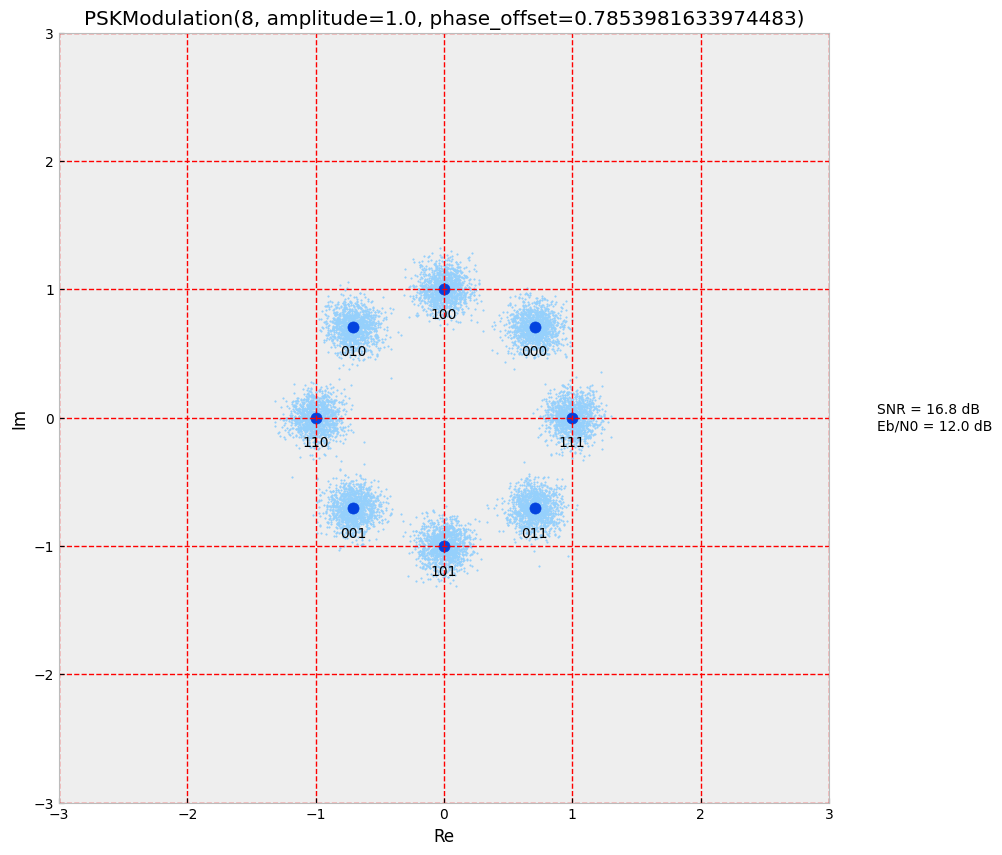

In [55]:
order = 8
base_amplitude=1 #Calculated by smartly guessing the value. (Or 7.7)
phase_offset=np.pi/4
labeling='natural'
noise_power_db=-16.8 # Could also just modify the amount of noise (with base amplitude of 7.7 noise power would be 1)

psk_constellation_demo(order, base_amplitude, phase_offset, labeling, noise_power_db)

**2. Numerical example:** Assume the following equation:

$$u_\mathrm{p}(t) = u_\mathrm{c}(t)\cos(2\pi 600 t) - u_\mathrm{s}(t)\sin(2\pi 600 t)$$

Considering an AWGN channel so that $E_b/N_0 = 12$dB, plot the wave form for a random binary sequence of $18$ bits considering an information rate of 300 bits per second.

Need to calculate the N0 so that the standard deviation of the noise can be calculated. Since Eb/N0 = 12dB is in log scale, need to convert to decimal (https://en.wikipedia.org/wiki/Decibel). Using this Lp = 10log10(Eb/N0) --> 12 = 10log10(Eb/N0) --> 1.2 = log10(Eb/N0) --> Eb/N0 = 10^1.2 --> Eb/N0 = 15.8489... ~= 15.85. To calculate the N0 we need to know the Eb which can be calculated using Es. Es means energy per symbol and from the picture above we can see that the Es = 1. Now we can calculate the Eb. Eb = Es/log2(M) --> Eb = 1/log2(8) --> Eb = 1/3. And now we can calculate the N0. Eb/N0 = 15.8489... --> Eb = 15.8489...*N0 --> Eb/15.8489... = N0 --> N0 = 0.02103... To dB -16.77dB. N0 = 2*sigma^2 --> sigma = sqrt(0.02103/2) --> sigma = 0.1025


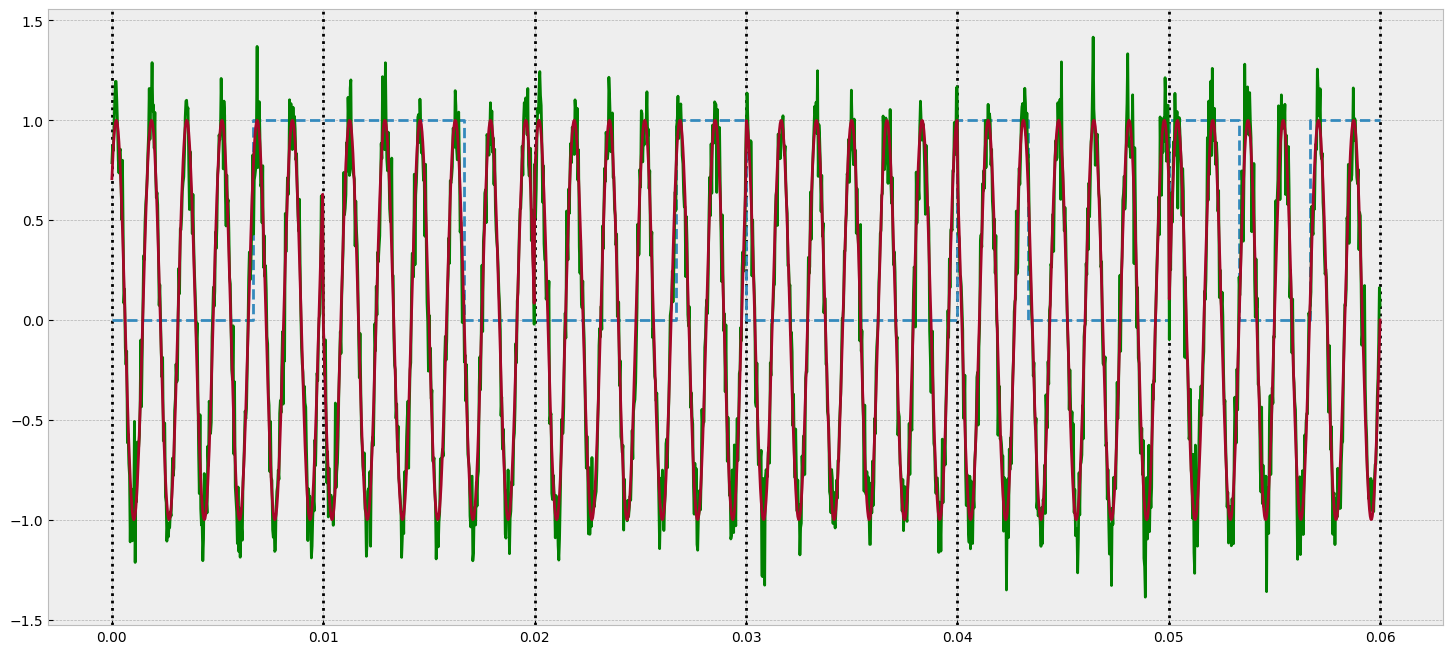

In [59]:
plt.rcParams['figure.figsize'] = 18, 8
M=8
psk=komm.PSKModulation(M)
observations = 6 
rate = 300
##
input_seq_size = observations * np.log2(M).astype(int)
time_of_obs = input_seq_size/rate
tp = np.arange(0, input_seq_size, 1)/rate 
input_seq = np.random.randint(2, size=input_seq_size)
input_seq_plot = np.append(input_seq,input_seq[input_seq_size-1])
tp_plot = np.append(tp,tp[input_seq_size-1]+1/rate)
##
n_samples = 100
tmod_points = n_samples*input_seq_size
tmod = np.linspace(0, tp_plot[input_seq_size], tmod_points)
##
input_wave_aux = psk.modulate(input_seq)
input_wave_I = np.zeros(tmod_points)
input_wave_Q = np.zeros(tmod_points)
for i in range(0,tmod_points):
    aux = math.floor(i/(n_samples*np.log2(M)))
    for j in range(M):
        if np.around(input_wave_aux[aux],decimals=3) == np.around(psk.constellation[j],decimals=3): 
            input_wave_I[i] = psk.constellation[j].real 
            input_wave_Q[i] = psk.constellation[j].imag
##
t = sp.symbols('t')

uc = sp.cos(2*sp.pi*600*t)
us = sp.sin(2*sp.pi*600*t)

modulation_I = sp.lambdify(t,uc,"numpy")
modulation_Q = sp.lambdify(t,us,"numpy")

for i in range(observations + 1):
    plt.axvline(i*np.log2(M)/rate,linestyle=':',color='k')
plt.step(tp_plot ,input_seq_plot,where='post',linestyle='--')

##
mu, sigma = 0, 0.1025 # mean and standard deviation
noiseQ = np.random.normal(mu, sigma, tmod_points)
noiseI = np.random.normal(mu, sigma, tmod_points)
plt.plot(tmod,(input_wave_I*modulation_I(tmod) + noiseI) - (input_wave_Q*modulation_Q(tmod) + noiseQ),'g')
plt.plot(tmod,input_wave_I*modulation_I(tmod) - input_wave_Q*modulation_Q(tmod))
plt.show()

**3. Performance analysis:** Plot the figure *error probability vs. $E_b/N_0$* assuming that the 0's and 1's in the input sequence are equally distributed. Consider two curves, symbol error probability and bit error probability.

- dmin = sqrt(2)/2
- Ndmin = 2 (picture)
- np = dmin^2/Eb = (sqrt(2)/2)^2/(1/3) = 1.5
- $P_\mathrm{e} \approx \bar{N}_{d_\mathrm{min}} Q\left( \sqrt{\dfrac{\eta_\mathrm{P} E_\mathrm{b}}{2N_0}} \right) = 2 Q\left( \sqrt{\dfrac{1.5 E_\mathrm{b}}{2N_0}} \right) = 2 Q\left(\sqrt{ \dfrac{3 E_\mathrm{b}}{4N_0} }\right) $

- $P_\mathrm{bit} = Q\left(\sqrt{ \dfrac{3 E_\mathrm{b}}{4N_0} }\right)$

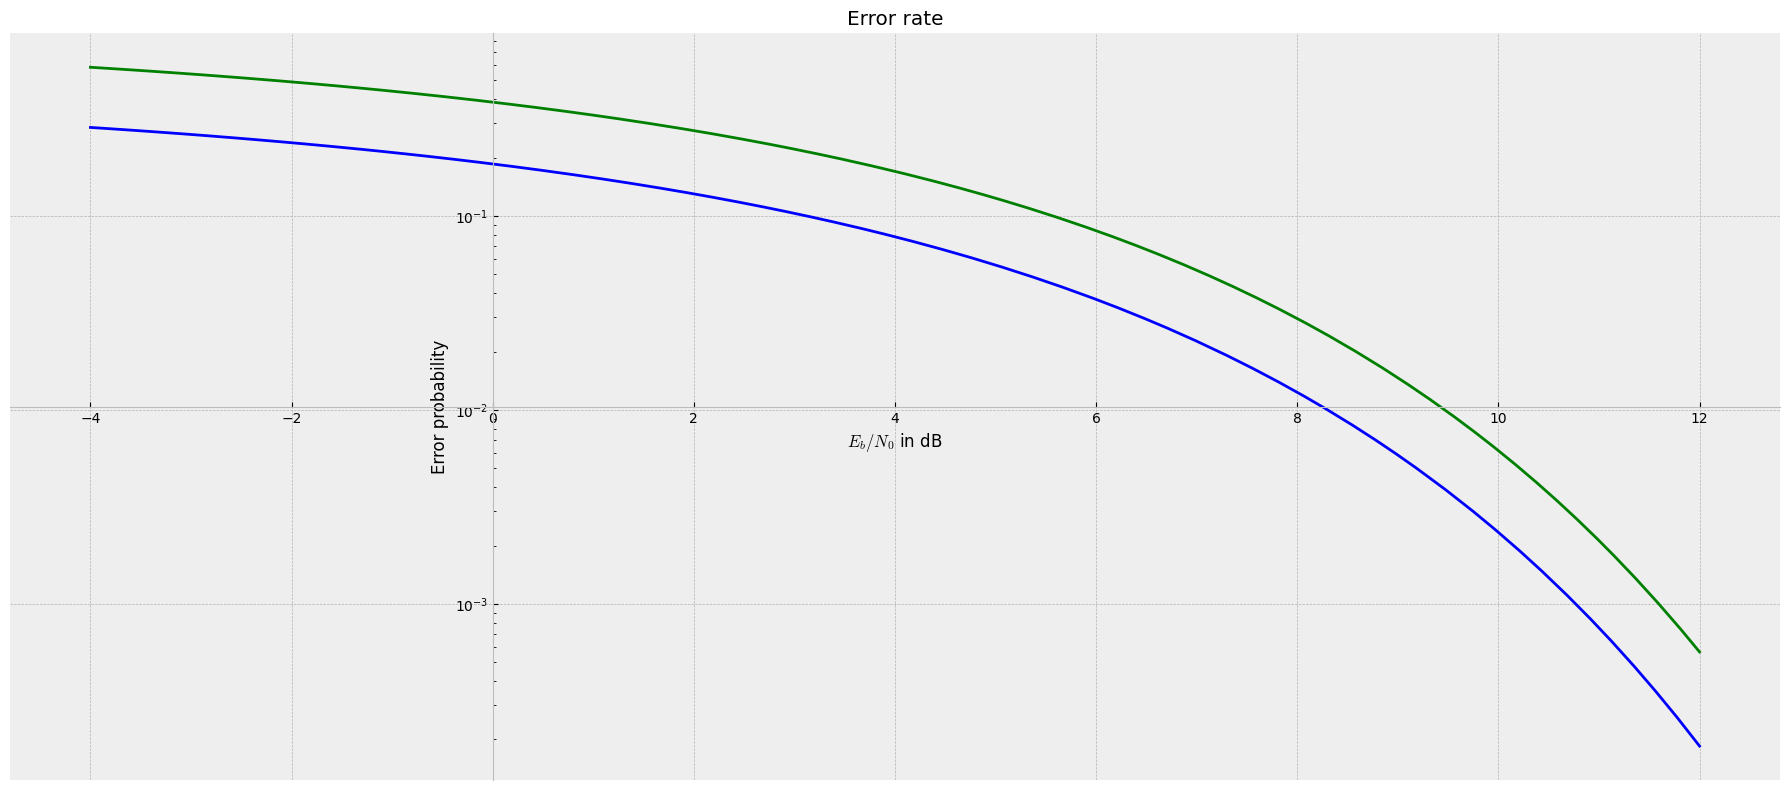

In [65]:
def Q(x):
    return sp.simplify(1/2 * sp.erfc(x/sp.sqrt(2)))
y = sp.Symbol("y")
plot_aux = sp.plot(sp.N(2*Q(sp.sqrt( 3/4 * 10**(y/10)))), sp.N(Q(sp.sqrt( 4/5 * 10**(y/10)))),(y,-4,12),xlabel='$E_b/N_0$ in dB',
        ylabel='Error probability', yscale= 'log', title='Error rate',show=False)
plot_aux[0].line_color = 'g'
plot_aux[1].line_color = 'b'
plot_aux.show()

**4. Decision rule:** If the input sequence is not equally distributed, the optimal decision rule changes. With your own words, explain why MAP outperforms ML.

Due to the noise in the transmission, we cannot be certain of the received signal so we need to make an assumption that maximises the probability that we interpret the received signal correctly. In the case of the input sequence not being equally distributed meaning that either 0 or 1 is more likely to occur than the other bit. In this case, the MAP outperforms ML since MAP takes into consideration the likelihood of the previous observations. In the input sequence example, it would take into consideration the distribution of the bits. If for example, we know that the input signal has way more 1's, MAP will shift the results to favor more the 1's which are more likely to appear in the signal. ML is weaker in this case since it assumes that both options have the same likelihood of happening so it doesn't take into consideration the past observations which is that the other bit is more likely to appear than the other one. 